## 날짜+시간 관련 부분 EDA(TIME-ZONE)

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# time-zone을 구해야하기 때문에 parsed_date=False
eml_df = pd.read_csv("../../parsed_eml_3.csv")

In [3]:
eml_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,file_name,/header/subject,/header/from,/header/to,/header/date,last_num,/header/received/0/src,...,/header/header/x-mailer-sid,/header/header/x-mailer-sent-by,/header/header/return-path,/header/cc,/header/header/x-virus-scanned,/header/header/cc,/header/received/0/src_at,ori_sender_ip,ori_sender_server,ori_receiver_mail
0,0,0,31644,0b200e46-d0f8-4219-8d9d-2266ad6c194d.eml,Ȳ򺸸 ΰ! 2̸ OK! usofq apqb,jjfkjsfjk4514262@nate.com,k003912@dumburo.com,2019-08-29 16:39:36+05:00,2,"from 58.248.209.14(58.248.209.14) at thu, 29 a...",...,NaN,NaN,NaN,NaN,NaN,NaN,"thu, 29 aug 2019 20:22:27 +0900",90.12.107.167,73.132.221.32,k003912@dumburo.com
1,1,1,31645,0b20dbf8-35fd-45e6-b519-5281d0fdedca.eml,ȭ BJ ̺ մϴ.,yenjuy@outlook.kr,hanh5@sannoroo.co.kr,2020-04-06 01:29:25+05:00,2,"from 122.97.133.171(122.97.133.171) at mon, 06...",...,NaN,NaN,NaN,NaN,NaN,NaN,"mon, 06 apr 2020 05:06:38 +0900",71.71.206.136,73.132.221.32,NaN
2,2,2,31646,0b20e0d1-4722-4573-a73e-e6636ba2e7b1.eml,Ȳ򺸸- ƴϳ׿. Ư ! ! l uruysc,hjas91546@naver.com,ps6601@greenrabbit.co.kr,2019-07-05 05:42:08-01:00,2,"from 219.139.240.195(219.139.240.195) at fri, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,"fri, 05 jul 2019 15:27:12 +0900",220.8.178.98,73.132.221.32,NaN
3,3,3,31647,0b20e7da-d2eb-4db2-8f08-e464ccabc9db.eml,IRA/401(k): Covid-19 is Sweeping the Nation,augusta_precious_metals@thgmj.work,april411@smmobi.com,2020-06-10 12:38:23-04:00,2,"from 92.118.114.40(92.118.114.40) at thu, 11 j...",...,NaN,NaN,NaN,NaN,NaN,NaN,"thu, 11 jun 2020 01:28:26 +0900",NaN,mail.thgmj.work,april411@smmobi.com
4,4,4,31648,0b20fbe7-bd8b-4b91-9883-dca6e14b1fe9.eml,Ich bin jetzt frei fr dich;),eugenespencero@etb.net.co,hkchoi70@windows4unix.net,2020-05-16 07:06:45+05:00,5,"from 200.119.125.194(200.119.125.194) at sat, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,"sat, 16 may 2020 11:40:25 +0900",114.111.202.91,qnx.mdrost.com,NaN


In [4]:
# 이전의 index값이 계속 쌓임, 일단 제거
del eml_df["Unnamed: 0"]
del eml_df["Unnamed: 0.1"]
del eml_df["Unnamed: 0.1.1"]

In [5]:
date_types = ["/header/date", "/header/header/date", "/header/received/0/src_at", 
             "/header/received/1/date", "/header/received/2/date",
             "/header/received/3/date", "/header/received/4/date", "/header/received/5/date"]

for date_type in date_types:
    #print(date_type)
    is_plus = eml_df[date_type].str.contains('+', na=False, regex=False)
    is_plus_and_nan = eml_df[date_type].str.contains('+', na=True, regex=False)
    
    # +hh:mm 형식 처리
    plus_series = eml_df[is_plus][date_type].str.split('+', expand=True)
    if not plus_series.empty:
        if len(plus_series.columns) != 2 and len(minus_series.columns) != 0: 
            print("**error** '+' 개수:", len(plus_series.columns))
        else:
            # /header/header/date는 +0500, 나머지는 +05:00 형식
            time_zone = plus_series[1].str.findall("\d\d")
            time_zone = time_zone.str.join('')
            time_zone = time_zone.str.rjust(5,'+')
            eml_df.loc[is_plus, date_type+'_timezone'] = time_zone
              
    # -hh:mm 형식 처리
    minus_series = (eml_df[~is_plus_and_nan][date_type].str.split('-', expand=True))
    if not minus_series.empty:
        if len(minus_series.columns) == 4:
            # /header/header/date는 +0500, 나머지는 +05:00 형식
            time_zone = minus_series[3].str.findall("\d\d")
            time_zone = time_zone.str.join('')
            time_zone = time_zone.str.rjust(5,'-')
            eml_df.loc[~is_plus_and_nan, date_type+'_timezone'] = time_zone
        elif len(minus_series.columns) == 2:
            # /header/header/date는 +0500, 나머지는 +05:00 형식
            time_zone = minus_series[1].str.findall("\d\d")
            time_zone = time_zone.str.join('')
            time_zone = time_zone.str.rjust(5,'-')
            eml_df.loc[~is_plus_and_nan, date_type+'_timezone'] = time_zone
        else:
            print("**error** '-' 개수: ", len(minus_ser))
                
    # null값 처리 -> 일단 시각화에 사용하기 위해 'NULL VALUE' 문자열 저장
    null_series = eml_df[date_type].isnull()
    temp_series = pd.Series(["NULL VALUE"]*len(null_series))
    eml_df.loc[null_series, date_type+"_timezone"] = temp_series

In [6]:
def visualization_datetime(df, column):
    plt.figure(figsize=(20,8))
    sns.countplot(x=column+'_timezone', data=df)
    plt.xticks(rotation=30, ha='right')
    plt.title(column+' Time Zone')
    plt.show()

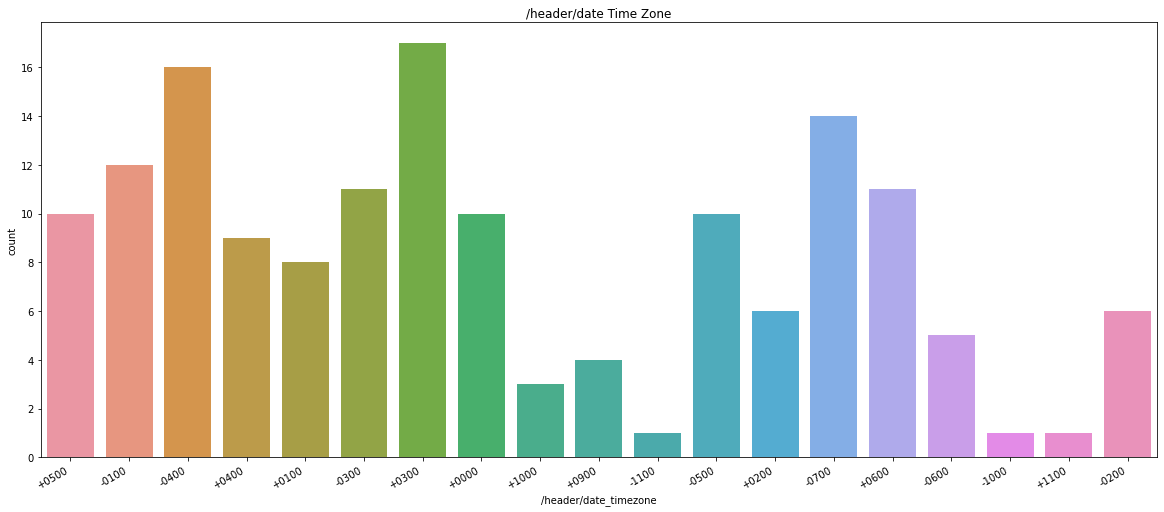

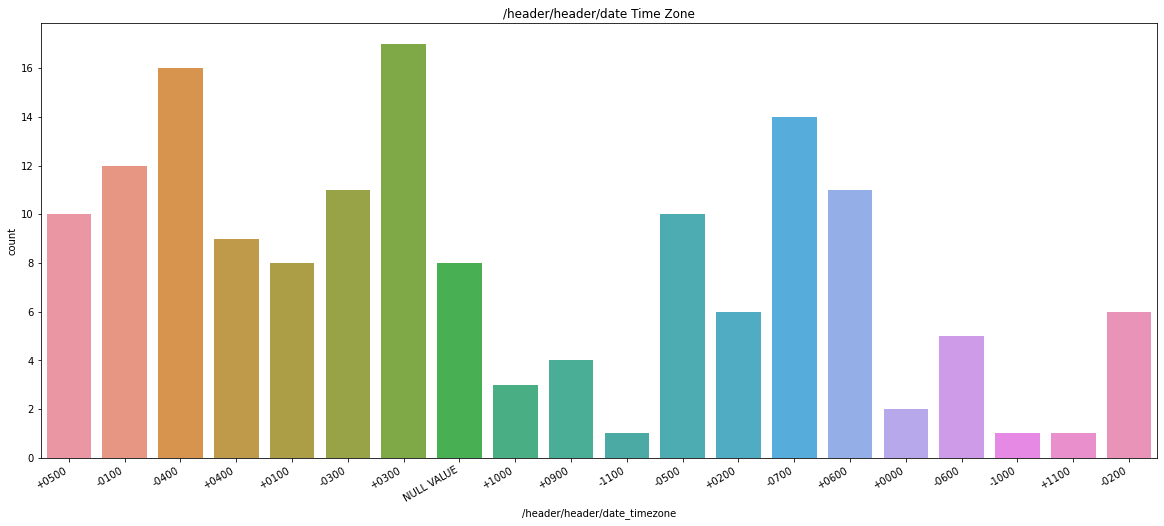

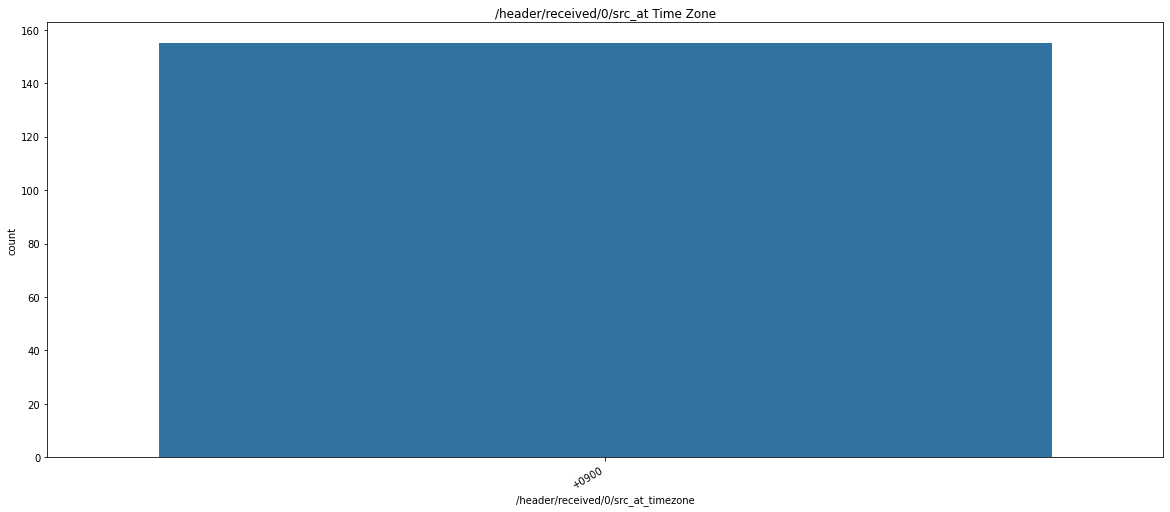

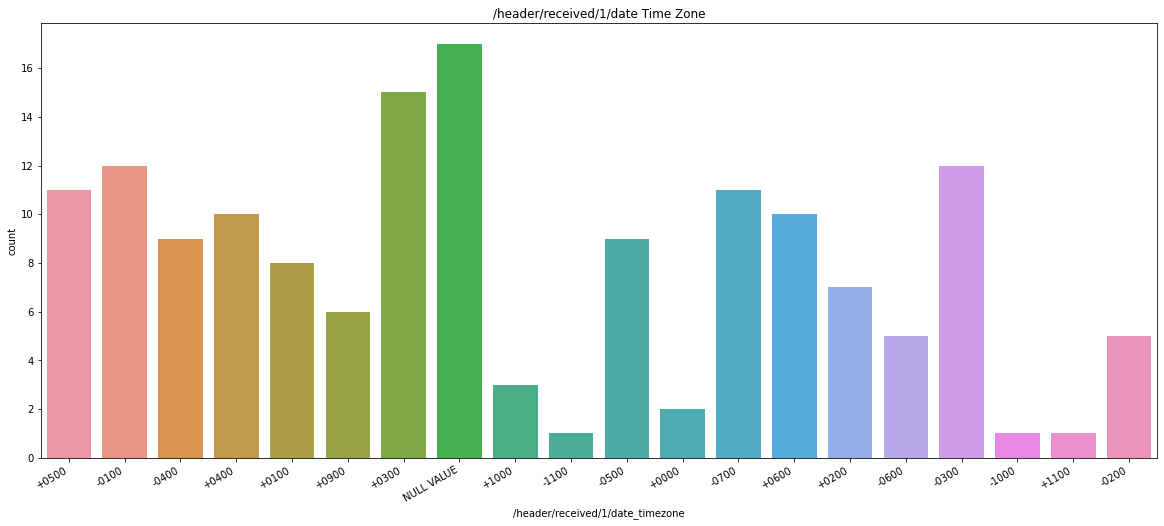

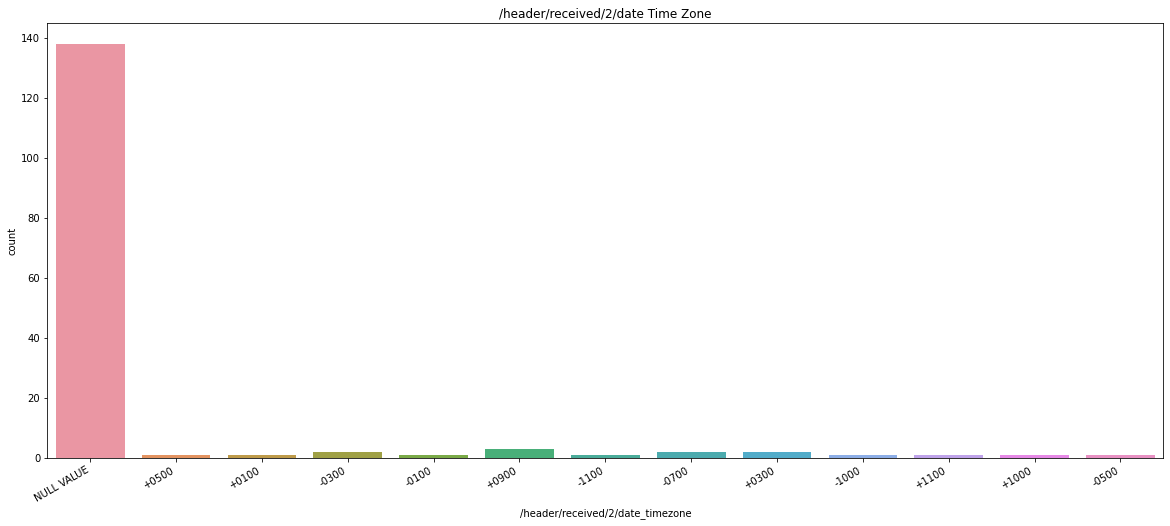

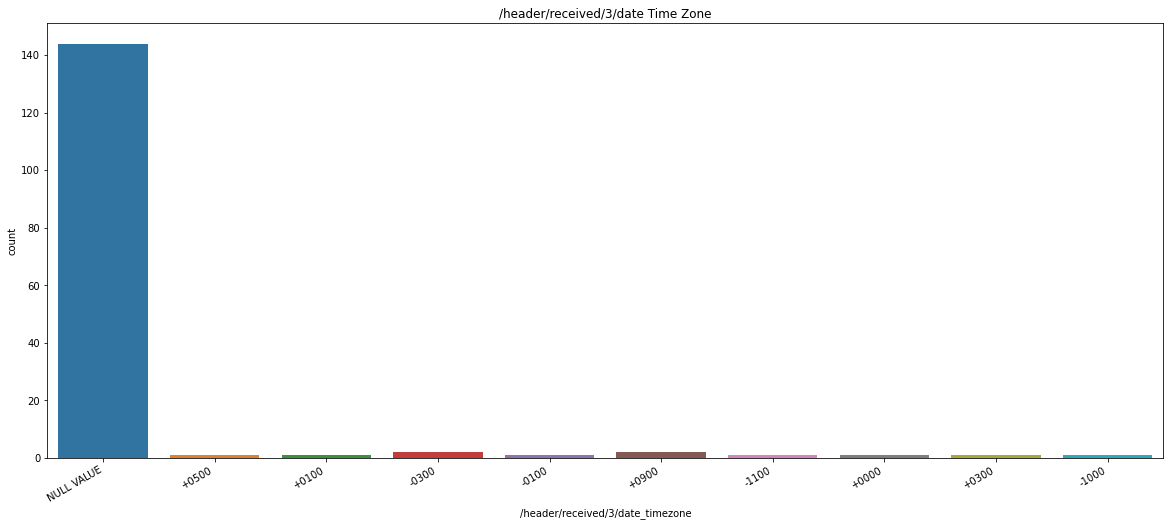

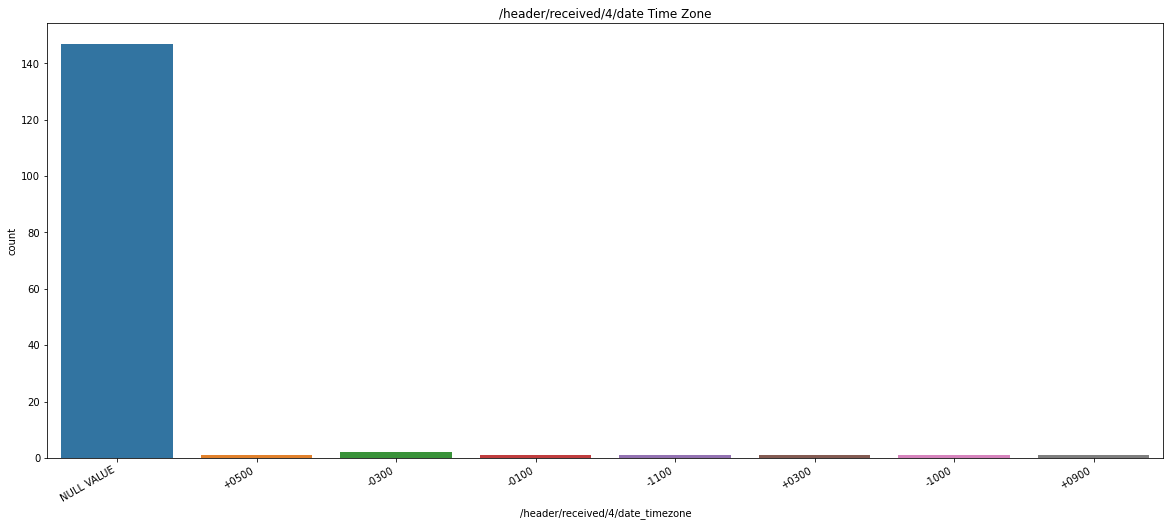

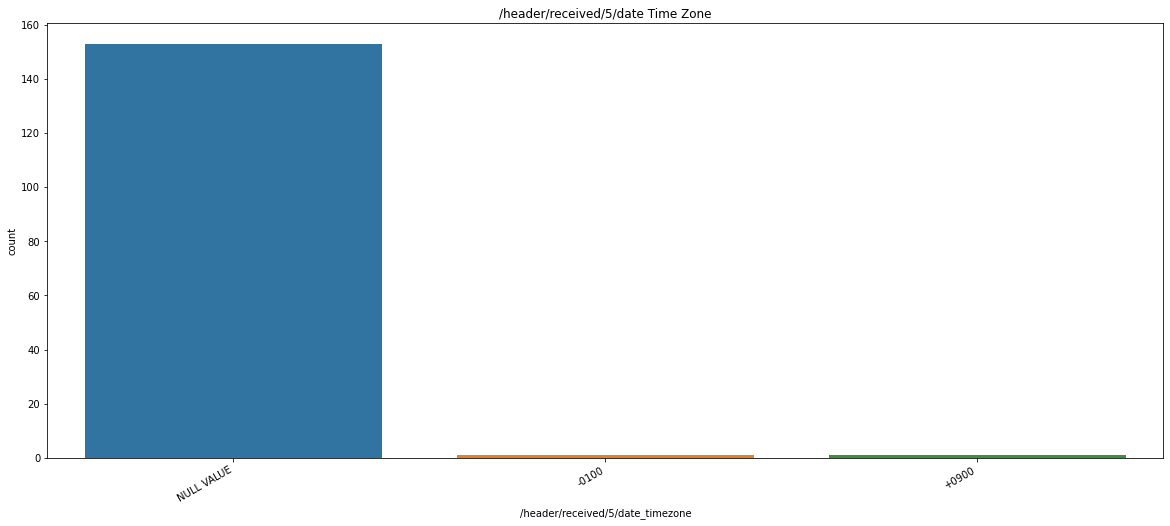

In [7]:
for date_type in date_types:
    visualization_datetime(eml_df, date_type)